## Markov switching dynamic regression models

This notebook provides an example of the use of Markov switching models in statsmodels to estimate dynamic regression models with changes in regime. It follows the examples in the Stata Markov switching documentation, which can be found at http://www.stata.com/manuals14/tsmswitch.pdf.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# NBER recessions
from pandas_datareader.data import DataReader
from datetime import datetime

usrec = DataReader(
    "USREC", "fred", start=datetime(1947, 1, 1), end=datetime(2013, 4, 1)
)

### Federal funds rate with switching intercept

The first example models the federal funds rate as noise around a constant intercept, but where the intercept changes during different regimes. The model is simply:

$$r_t = \mu_{S_t} + \varepsilon_t \qquad \varepsilon_t \sim N(0, \sigma^2)$$

where $S_t \in \{0, 1\}$, and the regime transitions according to

$$ P(S_t = s_t | S_{t-1} = s_{t-1}) =
\begin{bmatrix}
p_{00} & p_{10} \\
1 - p_{00} & 1 - p_{10}
\end{bmatrix}
$$

We will estimate the parameters of this model by maximum likelihood: $p_{00}, p_{10}, \mu_0, \mu_1, \sigma^2$.

The data used in this example can be found at https://www.stata-press.com/data/r14/usmacro.

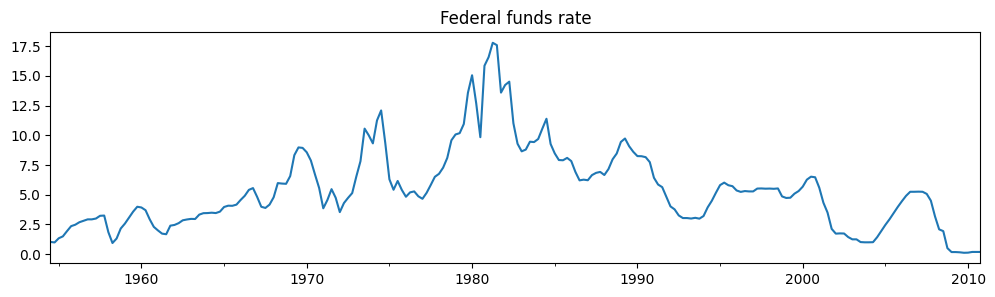

In [2]:
# Get the federal funds rate data
from statsmodels.tsa.regime_switching.tests.test_markov_regression import fedfunds

dta_fedfunds = pd.Series(
    fedfunds, index=pd.date_range("1954-07-01", "2010-10-01", freq="QS")
)

# Plot the data
dta_fedfunds.plot(title="Federal funds rate", figsize=(12, 3))

# Fit the model
# (a switching mean is the default of the MarkovRegession model)
mod_fedfunds = sm.tsa.MarkovRegression(dta_fedfunds, k_regimes=2)
res_fedfunds = mod_fedfunds.fit()

In [3]:
res_fedfunds.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      y   No. Observations:                  226
Model:               MarkovRegression   Log Likelihood                -508.636
Date:                Fri, 01 Sep 2023   AIC                           1027.272
Time:                        08:57:21   BIC                           1044.375
Sample:                    07-01-1954   HQIC                          1034.174
                         - 10-01-2010                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7088      0.177     20.988      0.000       3.362       4.055
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.5568      0.300     31.857      0.000       8.969      10.145
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.4418      0.425     10.447      0.000       3.608       5.275
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9821      0.010     94.443      0.000       0.962       1.002
p[1->0]        0.0504      0.027      1.876      0.061      -0.002       0.103
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

From the summary output, the mean federal funds rate in the first regime (the "low regime") is estimated to be $3.7$ whereas in the "high regime" it is $9.6$. Below we plot the smoothed probabilities of being in the high regime. The model suggests that the 1980's was a time-period in which a high federal funds rate existed.

<Axes: title={'center': 'Probability of being in the high regime'}>

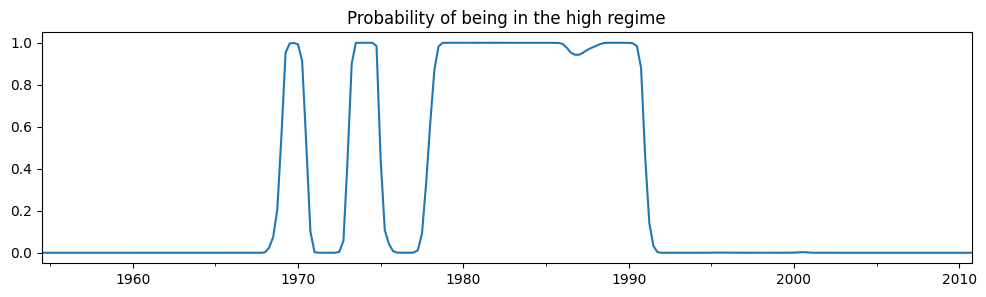

In [4]:
res_fedfunds.smoothed_marginal_probabilities[1].plot(
    title="Probability of being in the high regime", figsize=(12, 3)
)

From the estimated transition matrix we can calculate the expected duration of a low regime versus a high regime.

In [5]:
print(res_fedfunds.expected_durations)

[55.85400626 19.85506546]


A low regime is expected to persist for about fourteen years, whereas the high regime is expected to persist for only about five years.

### Federal funds rate with switching intercept and lagged dependent variable

The second example augments the previous model to include the lagged value of the federal funds rate.

$$r_t = \mu_{S_t} + r_{t-1} \beta_{S_t} + \varepsilon_t \qquad \varepsilon_t \sim N(0, \sigma^2)$$

where $S_t \in \{0, 1\}$, and the regime transitions according to

$$ P(S_t = s_t | S_{t-1} = s_{t-1}) =
\begin{bmatrix}
p_{00} & p_{10} \\
1 - p_{00} & 1 - p_{10}
\end{bmatrix}
$$

We will estimate the parameters of this model by maximum likelihood: $p_{00}, p_{10}, \mu_0, \mu_1, \beta_0, \beta_1, \sigma^2$.

In [6]:
# Fit the model
mod_fedfunds2 = sm.tsa.MarkovRegression(
    dta_fedfunds.iloc[1:], k_regimes=2, exog=dta_fedfunds.iloc[:-1]
)
res_fedfunds2 = mod_fedfunds2.fit()

In [7]:
res_fedfunds2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      y   No. Observations:                  225
Model:               MarkovRegression   Log Likelihood                -264.711
Date:                Fri, 01 Sep 2023   AIC                            543.421
Time:                        08:57:22   BIC                            567.334
Sample:                    10-01-1954   HQIC                           553.073
                         - 10-01-2010                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7245      0.289      2.510      0.012       0.159       1.290
x1             0.7631      0.034     22.629      0.000       0.697       0.829
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0989      0.118     -0.835      0.404      -0.331       0.133
x1             1.0612      0.019     57.351      0.000       1.025       1.097
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.4783      0.050      9.642      0.000       0.381       0.576
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.6378      0.120      5.304      0.000       0.402       0.874
p[1->0]        0.1306      0.050      2.634      0.008       0.033       0.228
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

There are several things to notice from the summary output:

1. The information criteria have decreased substantially, indicating that this model has a better fit than the previous model.
2. The interpretation of the regimes, in terms of the intercept, have switched. Now the first regime has the higher intercept and the second regime has a lower intercept.

Examining the smoothed probabilities of the high regime state, we now see quite a bit more variability.

<Axes: title={'center': 'Probability of being in the high regime'}>

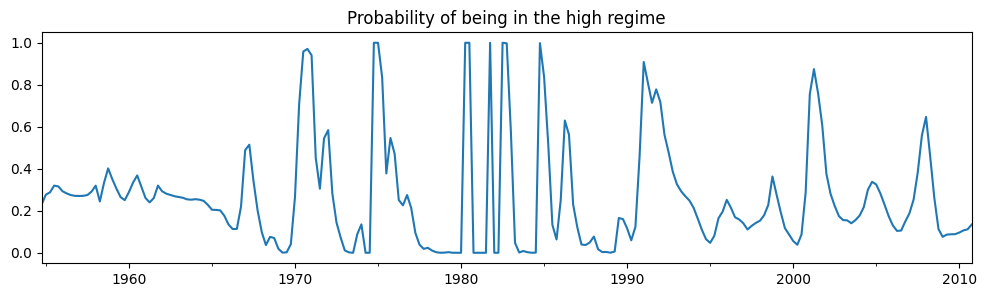

In [8]:
res_fedfunds2.smoothed_marginal_probabilities[0].plot(
    title="Probability of being in the high regime", figsize=(12, 3)
)

Finally, the expected durations of each regime have decreased quite a bit.

In [9]:
print(res_fedfunds2.expected_durations)

[2.76105188 7.65529154]


### Taylor rule with 2 or 3 regimes

We now include two additional exogenous variables - a measure of the output gap and a measure of inflation - to estimate a switching Taylor-type rule with both 2 and 3 regimes to see which fits the data better.

Because the models can be often difficult to estimate, for the 3-regime model we employ a search over starting parameters to improve results, specifying 20 random search repetitions.

In [10]:
# Get the additional data
from statsmodels.tsa.regime_switching.tests.test_markov_regression import ogap, inf

dta_ogap = pd.Series(ogap, index=pd.date_range("1954-07-01", "2010-10-01", freq="QS"))
dta_inf = pd.Series(inf, index=pd.date_range("1954-07-01", "2010-10-01", freq="QS"))

exog = pd.concat((dta_fedfunds.shift(), dta_ogap, dta_inf), axis=1).iloc[4:]

# Fit the 2-regime model
mod_fedfunds3 = sm.tsa.MarkovRegression(dta_fedfunds.iloc[4:], k_regimes=2, exog=exog)
res_fedfunds3 = mod_fedfunds3.fit()

# Fit the 3-regime model
np.random.seed(12345)
mod_fedfunds4 = sm.tsa.MarkovRegression(dta_fedfunds.iloc[4:], k_regimes=3, exog=exog)
res_fedfunds4 = mod_fedfunds4.fit(search_reps=20)

In [11]:
res_fedfunds3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      y   No. Observations:                  222
Model:               MarkovRegression   Log Likelihood                -229.256
Date:                Fri, 01 Sep 2023   AIC                            480.512
Time:                        08:57:27   BIC                            517.942
Sample:                    07-01-1955   HQIC                           495.624
                         - 10-01-2010                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6555      0.137      4.771      0.000       0.386       0.925
x1             0.8314      0.033     24.951      0.000       0.766       0.897
x2             0.1355      0.029      4.609      0.000       0.078       0.193
x3            -0.0274      0.041     -0.671      0.502      -0.107       0.053
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0945      0.128     -0.739      0.460      -0.345       0.156
x1             0.9293      0.027     34.309      0.000       0.876       0.982
x2             0.0343      0.024      1.429      0.153      -0.013       0.081
x3             0.2125      0.030      7.147      0.000       0.154       0.271
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.3323      0.035      9.526      0.000       0.264       0.401
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.7279      0.093      7.828      0.000       0.546       0.910
p[1->0]        0.2115      0.064      3.298      0.001       0.086       0.337
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [12]:
res_fedfunds4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      y   No. Observations:                  222
Model:               MarkovRegression   Log Likelihood                -180.806
Date:                Fri, 01 Sep 2023   AIC                            399.611
Time:                        08:57:27   BIC                            464.262
Sample:                    07-01-1955   HQIC                           425.713
                         - 10-01-2010                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0250      0.290     -3.531      0.000      -1.594      -0.456
x1             0.3277      0.086      3.812      0.000       0.159       0.496
x2             0.2036      0.049      4.152      0.000       0.107       0.300
x3             1.1381      0.081     13.977      0.000       0.978       1.298
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0259      0.087     -0.298      0.765      -0.196       0.144
x1             0.9737      0.019     50.265      0.000       0.936       1.012
x2             0.0341      0.017      2.030      0.042       0.001       0.067
x3             0.1215      0.022      5.606      0.000       0.079       0.164
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7346      0.130      5.632      0.000       0.479       0.990
x1             0.8436      0.024     35.198      0.000       0.797       0.891
x2             0.1633      0.025      6.515      0.000       0.114       0.212
x3            -0.0499      0.027     -1.835      0.067      -0.103       0.003
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1660      0.018      9.240      0.000       0.131       0.201
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.7214      0.117      6.177      0.000       0.493       0.950
p[1->0]     4.001e-08        nan        nan        nan         nan         nan
p[2->0]        0.0783      0.038      2.079      0.038       0.004       0.152
p[0->1]        0.1044      0.095      1.103      0.270      -0.081       0.290
p[1->1]        0.8259      0.054     15.208      0.000       0.719       0.932
p[2->1]        0.2288      0.073      3.150      0.002       0.086       0.371
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differ

Due to lower information criteria, we might prefer the 3-state model, with an interpretation of low-, medium-, and high-interest rate regimes. The smoothed probabilities of each regime are plotted below.

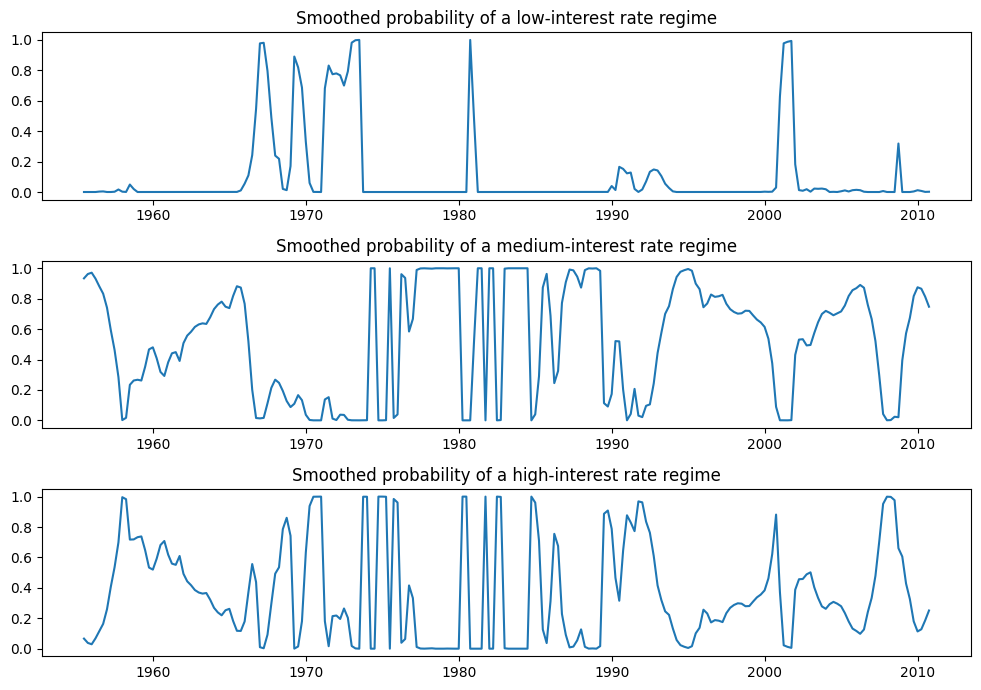

In [13]:
fig, axes = plt.subplots(3, figsize=(10, 7))

ax = axes[0]
ax.plot(res_fedfunds4.smoothed_marginal_probabilities[0])
ax.set(title="Smoothed probability of a low-interest rate regime")

ax = axes[1]
ax.plot(res_fedfunds4.smoothed_marginal_probabilities[1])
ax.set(title="Smoothed probability of a medium-interest rate regime")

ax = axes[2]
ax.plot(res_fedfunds4.smoothed_marginal_probabilities[2])
ax.set(title="Smoothed probability of a high-interest rate regime")

fig.tight_layout()

### Switching variances

We can also accommodate switching variances. In particular, we consider the model

$$
y_t = \mu_{S_t} + y_{t-1} \beta_{S_t} + \varepsilon_t \quad \varepsilon_t \sim N(0, \sigma_{S_t}^2)
$$

We use maximum likelihood to estimate the parameters of this model: $p_{00}, p_{10}, \mu_0, \mu_1, \beta_0, \beta_1, \sigma_0^2, \sigma_1^2$.

The application is to absolute returns on stocks, where the data can be found at https://www.stata-press.com/data/r14/snp500.

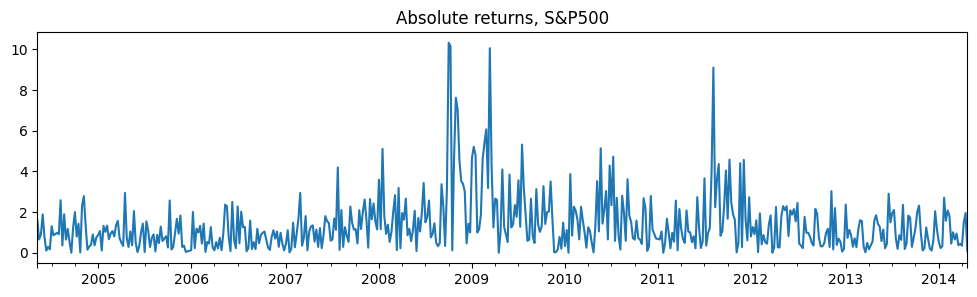

In [14]:
# Get the federal funds rate data
from statsmodels.tsa.regime_switching.tests.test_markov_regression import areturns

dta_areturns = pd.Series(
    areturns, index=pd.date_range("2004-05-04", "2014-5-03", freq="W")
)

# Plot the data
dta_areturns.plot(title="Absolute returns, S&P500", figsize=(12, 3))

# Fit the model
mod_areturns = sm.tsa.MarkovRegression(
    dta_areturns.iloc[1:],
    k_regimes=2,
    exog=dta_areturns.iloc[:-1],
    switching_variance=True,
)
res_areturns = mod_areturns.fit()

In [15]:
res_areturns.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      y   No. Observations:                  520
Model:               MarkovRegression   Log Likelihood                -745.798
Date:                Fri, 01 Sep 2023   AIC                           1507.595
Time:                        08:57:30   BIC                           1541.626
Sample:                    05-16-2004   HQIC                          1520.926
                         - 04-27-2014                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7641      0.078      9.761      0.000       0.611       0.918
x1             0.0791      0.030      2.620      0.009       0.020       0.138
sigma2         0.3476      0.061      5.694      0.000       0.228       0.467
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9728      0.278      7.086      0.000       1.427       2.518
x1             0.5280      0.086      6.155      0.000       0.360       0.696
sigma2         2.5771      0.405      6.357      0.000       1.783       3.372
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.7531      0.063     11.871      0.000       0.629       0.877
p[1->0]        0.6825      0.066     10.301      0.000       0.553       0.812
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

The first regime is a low-variance regime and the second regime is a high-variance regime. Below we plot the probabilities of being in the low-variance regime. Between 2008 and 2012 there does not appear to be a clear indication of one regime guiding the economy.

<Axes: title={'center': 'Probability of being in a low-variance regime'}>

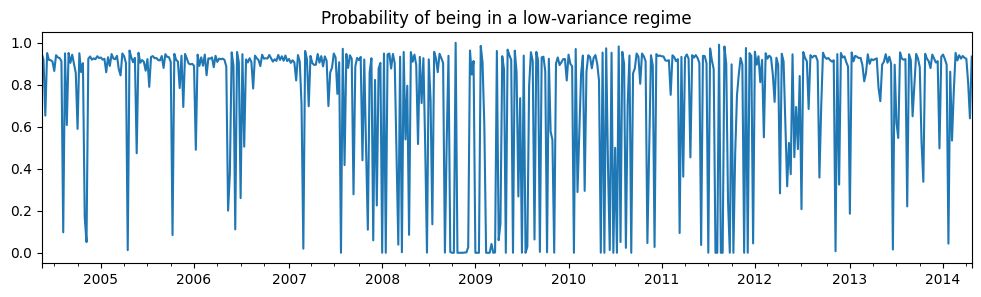

In [16]:
res_areturns.smoothed_marginal_probabilities[0].plot(
    title="Probability of being in a low-variance regime", figsize=(12, 3)
)